# Naive Bayes Model

In this notebook, a Naive Bayes model is run on a iid sampled data set of approximately 250K rows of data.  This notebook was run on an AWS SageMaker ml.c5.4xlarge instance.

#### Import modules

In [1]:
import pandas as pd
import string
import re
import string
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.stem import LancasterStemmer 

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
import feature_generation_functions as fgf

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import model_functions as mf

In [4]:
import pickle_functions as pf

### Load and shuffle data

In [5]:
# train = pd.read_csv("s3://advancedml-koch-mathur-hinkson/train.csv")

In [6]:
train.shape

(1804874, 45)

Label comments as toxic ("1") or nontoxic ("0") using 0.5 threshold

In [7]:
train['toxicity_category'] = train.target.apply(lambda x: 1 if x > 0.5 else 0)

In [8]:
train.shape

(1804874, 46)

Split into train_set and validation_set

In [9]:
#Citation: https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
msk = np.random.rand(len(train)) < 0.8
train_set = train[msk]
hold_out_set = train[~msk]


In [10]:
print(train_set.toxicity_category.value_counts())

0    1358996
1      85262
Name: toxicity_category, dtype: int64


In [11]:
print(hold_out_set.toxicity_category.value_counts())

0    339440
1     21176
Name: toxicity_category, dtype: int64


Randomly sample train_set to create a smaller data frame (train_sample) to run NB on

In [12]:
train_sample = train_set.sample(frac=0.75, replace=True)

In [13]:
print(train_sample.toxicity_category.value_counts())

0    1018765
1      64429
Name: toxicity_category, dtype: int64


### Generate features

In [14]:
train_df = fgf.generate_NB_SVM_features(train_sample)

Cleaned with stopwords...Elapsed Time:  0.265 minutes
Cleaned without stopwords...Elapsed Time:  0.368 minutes
Stemmed (Porter)...Elapsed Time:  8.513 minutes
Stemmed (Lancaster)...Elapsed Time:  7.019 minutes

DONE GENERATING FEATURES


In [15]:
pf.write_pickle_to_s3bucket(filename='NB_final_1M', 
                            bucket_name='advancedml-koch-mathur-hinkson', 
                            df=train_df)

Pickled and sent to bucket!


In [16]:
hold_out_df = fgf.generate_NB_SVM_features(hold_out_set)

Cleaned with stopwords...Elapsed Time:  0.088 minutes
Cleaned without stopwords...Elapsed Time:  0.123 minutes
Stemmed (Porter)...Elapsed Time:  2.788 minutes
Stemmed (Lancaster)...Elapsed Time:  2.291 minutes

DONE GENERATING FEATURES


In [17]:
pf.write_pickle_to_s3bucket(filename='NB_final_holdout_350K', 
                            bucket_name='advancedml-koch-mathur-hinkson', 
                            df=hold_out_df)

Pickled and sent to bucket!


### Reshaping & Weighting

Reshape the dataset to include an equal number of toxic and nontoxic samples

In [6]:
train_df = pf.read_pickle(filename='NB_final_1M', bucket_name='advancedml-koch-mathur-hinkson')


In [7]:
hold_out_df = pf.read_pickle(filename='NB_final_holdout_350K', bucket_name='advancedml-koch-mathur-hinkson')


In [8]:
toxic = train_df[train_df.toxicity_category == 1]
nontoxic = train_df[train_df.toxicity_category == 0]

In [9]:
train_df.shape, toxic.shape, nontoxic.shape

((1083194, 50), (64429, 50), (1018765, 50))

In [10]:
quarter = len(toxic)
ten_percent = round((len(toxic) / 5) * 2)

In [11]:
ten_percent * 4

103088

In [12]:
random_df = train_df.sample(quarter*4)

In [13]:
prepared_50 = toxic.append(toxic).append(nontoxic.sample(len(toxic)*2))
prepared_50 = prepared_50.sample(frac=1).reset_index(drop=True)
print(prepared_50.toxicity_category.value_counts())

1    128858
0    128858
Name: toxicity_category, dtype: int64


### Naive Bayes - weighted 50% toxic, 50% nontoxic

From NB_iter4 notebook we learned that cleaned_no_stem_str was the feature that yeilded the highest performing model results.

In [14]:
classifier, output, fitted_vectorizer = mf.run_model(model_df=prepared_50, 
                                                     model_type="MultiNB", 
                                                     comments = "cleaned_no_stem_str", 
                                                     train_perc=0.8, 
                                                     target="toxicity_category", 
                                                     see_inside=False)

fitting model now


In [15]:
mf.get_metrics(output=output, detailed=True, should_print=True, round_to=3)

Overall Accuracy: 0.821624662902819
Overall Precision: 0.7826682651138893
Overall Recall: 0.8891396552395034
Overall F1 Score: 0.8325135716107407
ROC_AUC: 0.822

Target Accuracy: 0.8891396552395034
Target Precision: 1.0
Target Recall: 0.8891396552395034
Target F1 Score: 0.941317019918021

Non-Target Accuracy: 0.7544884692772017
Non-Target Precision: 1.0
Non-Target Recall: 0.7544884692772017
Non-Target F1 Score: 0.8600666034448536

Strong Identity Accuracy: 0.9108061749571184
Strong Identity Precision: 0.9974937343358395
Strong Identity Recall: 0.9128440366972477
Strong Identity F1 Score: 1.0

Obscenity Accuracy: 0.8790366721401204
Obscenity Precision: 1.0
Obscenity Recall: 0.8789041095890411
Obscenity F1 Score: 1.0

Insults Accuracy: 0.9016768698429598
Insults Precision: 0.9988791221756829
Insults Recall: 0.9025586353944562
Insults F1 Score: 1.0

Threats Accuracy: 0.8716502115655853
Threats Precision: 1.0
Threats Recall: 0.8716502115655853
Threats F1 Score: 1.0



{'Overall': {'Accuracy': 0.821624662902819,
  'Precision': 0.7826682651138893,
  'Recall': 0.8891396552395034,
  'F1': 0.8325135716107407,
  'ROC_AUC': 0.822},
 'Target': {'Accuracy': 0.8891396552395034,
  'Precision': 1.0,
  'Recall': 0.8891396552395034,
  'F1': 0.941317019918021},
 'Non-Target': {'Accuracy': 0.8716502115655853,
  'Precision': 1.0,
  'Recall': 0.8716502115655853,
  'F1': 1.0}}

In [16]:
hold_out_results = mf.run_model_test(model_df=hold_out_df, 
                                     clf=classifier, 
                                     vectorizer=fitted_vectorizer, 
                                     comments="cleaned_no_stem_str", target="toxicity_category")

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count',
       'toxicity_category', 'cleaned_w_stopwords_str', 'cleaned_no_stem_str',
       'cleaned_porter_str', 'cleaned_lancaster_str', 'predicted', 'y_test'],
      dtype='object')


In [17]:
# hold_out_results.to_csv("holdout_results", sep='|')

In [18]:
hold_out_metrics = mf.get_metrics(output=hold_out_results, detailed=True, should_print=True, round_to=3)

Overall Accuracy: 0.759511502540098
Overall Precision: 0.1755627709913085
Overall Recall: 0.8375047223271628
Overall F1 Score: 0.290276118303681
ROC_AUC: 0.796

Target Accuracy: 0.8375047223271628
Target Precision: 1.0
Target Recall: 0.8375047223271628
Target F1 Score: 0.9115674230937266

Non-Target Accuracy: 0.7546458873438605
Non-Target Precision: 1.0
Non-Target Recall: 0.7546458873438605
Non-Target F1 Score: 0.8601688725765911

Strong Identity Accuracy: 0.8375499334221038
Strong Identity Precision: 0.9451737451737452
Strong Identity Recall: 0.8761632068718683
Strong Identity F1 Score: 1.0

Obscenity Accuracy: 0.8297734627831715
Obscenity Precision: 0.9945141065830722
Obscenity Recall: 0.8321311475409836
Obscenity F1 Score: 1.0

Insults Accuracy: 0.8423837722061233
Insults Precision: 0.9816527335947326
Insults Recall: 0.854796108999549
Insults F1 Score: 1.0

Threats Accuracy: 0.8406593406593407
Threats Precision: 0.978401727861771
Threats Recall: 0.8547169811320755
Threats F1 Score: 

### Feature generation

In [20]:
feature_names = fitted_vectorizer.get_feature_names()

In [21]:
imp = classifier.coef_.tolist()[0]
imp2, names = zip(*sorted(zip(imp,feature_names)))

In [25]:
imps = imp2[-10:] + imp2[:10]
words = names[-10:] + names[:10]

In [30]:
tograph = pd.DataFrame()
tograph['importances'] = imps
tograph['words'] = words
tograph['type'] = tograph.importances.apply(lambda x: 1 if x > 0 else 0)

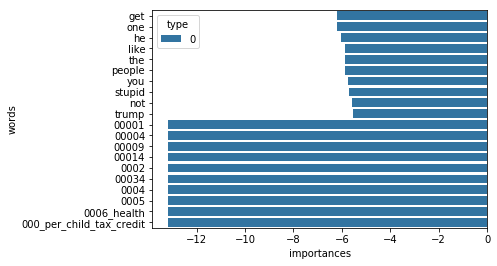

In [31]:
sns.barplot(x="importances", y="words", data=tograph, hue="type")